# Generating Shells (BM Model)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Define rotation matrix and some constants

In [2]:
def rotation_matrix(theta):
    """Create 2D rotation matrix"""
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

In [3]:
a = 1.42  # Angstroms

# Direct lattice vectors
a1 = a * np.array([np.sqrt(3), 0])
a2 = a / 2 * np.array([-np.sqrt(3), 3])

# Reciprocal lattice vectors
G_1 = 2 * np.pi / a * np.array([1 / np.sqrt(3), 1 / 3])
G_2 = 2 * np.pi / a * np.array([0, 2 / 3])

phi = 2 * np.pi / 3
w = 110  # meV
w_1 = w
factor = 1
w_0 = factor * w_1
T_b = np.array([[w_0, w_1], [w_1, w_0]])  # Hopping matrix in k space

# Jung paper version
T_tl = np.array([[w_0, w_1 * np.exp(-1j * phi)], [w_1 * np.exp(1j * phi), w_0]])  # Hopping matrix in k space
T_tr = np.array([[w_0, w_1 * np.exp(1j * phi)], [w_1 * np.exp(-1j * phi), w_0]])  # Hopping matrix in k space

# BM Paper version -- equivalent to Jung paper version
# T_tr = w * np.array([[np.exp(-1j * phi), 1], [np.exp(1j * phi), np.exp(-1j * phi)]])
# T_tl = w * np.array([[np.exp(1j * phi), 1], [np.exp(-1j * phi), np.exp(1j * phi)]])

In [4]:
#### Twist angle
theta = 1 * np.pi / 180

# Reciprocal lattice vectors of twisted layer
G_1r = rotation_matrix(theta) @ G_1
G_2r = rotation_matrix(theta) @ G_2

K_1 = (G_1 + G_2) / 3
K_1r = (G_1r + G_2r) / 3
k_theta = np.linalg.norm(K_1r - K_1)  # Moire 1st BZ sidelength

# Hopping vectors in k space
q_b = k_theta * np.array([0, -1])
q_tl = k_theta * np.array([-np.sqrt(3), 1]) / 2
q_tr = k_theta * np.array([np.sqrt(3), 1]) / 2

# Moire reciprocal lattice vectors
M_1 = q_tr - q_tl
M_2 = q_tr - q_b
M_3 = q_tl - q_b
M_4 = q_tl - q_tr
M_5 = q_b - q_tr
M_6 = q_b - q_tl

## Generate "shells" (momenta within a cutoff radius)

In [5]:
def search(m, cutoff, k, prev_id, curr_id, direction):
    """Search for a neighbor
    Args:
    - m (int): a number that basically tells us whether we are in the top
               layer or bottom layer
    - cutoff (float): maximum momentum of any site we use for the band calculation
    - k (np.array): k vector of current momentum site
    - prev_id (int): Index of previous momentum site during the search
    - curr_id (int): Index of current momentum site being searched
    - direction (int): Either -1, 0, or 1, corresponding to which direction we had
                       to travel to get from the previous site to the current site

    Returns:
    - prev_id (int): Index of the current site (which will be the previous site
                     for the next search)
    - curr_id (int): Same value as prev_id except in cases where the site is 
                     outside the cutoff or has already been searched, in which case
                     curr_id is equal to -1
    """
    # Return -1 as the curr_id if we are outside the cutoff radius, indicating that
    # we should stop searching this branch
    if np.linalg.norm(k) > cutoff:
        return prev_id, -1

    # Looks cryptic, but basically if we arrive at a site that has already been
    # searched, then we should just include it as a neighbor of the previous
    # site (and vice versa) and then stop searching this branch
    if len([idx for idx, el in enumerate(list(k_dict.values())) if np.allclose(el, k)]) > 0:
        curr_id = list(k_dict.keys())[[idx for idx, el in enumerate(list(k_dict.values())) if np.allclose(el, k)][0]]
        neighbors_dict[prev_id].add((curr_id, direction))
        neighbors_dict[curr_id].add((prev_id, direction))
        return prev_id, -1

    # If none of the above are true, then we have arrived at a new site that
    # should be included in our band calculations, so we generate a new index
    # for that site
    while curr_id in visited_list:
        curr_id += 1

    # Add the current site as a neighbor of the previous site (and vice versa). 
    # I don't remember why I used a set instead of a list of neighbors--presumably
    # I was having problems with duplicates, so using a set resolved that problem
    if prev_id not in neighbors_dict:
        neighbors_dict[prev_id] = set([(curr_id, direction)])
    else:
        neighbors_dict[prev_id].add((curr_id, direction))
    if curr_id not in neighbors_dict:
        neighbors_dict[curr_id] = set([(prev_id, direction)])
    else:
        neighbors_dict[curr_id].add((prev_id, direction))

    # Mark the site as visited and record its momentum and layer (1 if top layer
    # and -1 if bottom layer)
    visited_list.append(curr_id)
    k_dict[curr_id] = k
    layer_dict[curr_id] = 1 if m % 2 == 1 else -1
    prev_id = curr_id
    return prev_id, curr_id

In [6]:
# These functions may be redundant, but they were the most systematic way I
# could think of at the time

# Search "curr_id" by traveling q_b (or -q_b) from "prev_id"
def search_b(m, cutoff, k, prev_id, curr_id):
    prev_id, curr_id = search(m, cutoff, k, prev_id, curr_id, 0)

    # Stop searching if any of the conditions in "search" were met
    if curr_id == -1:
        return

    # Else, search the top right, then the top left (order is arbitrary).
    # The value of m determine whether we need to add or subtract q_tr or
    # q_tl from our current k vector to get to the next site
    search_tr(m - 1, cutoff, k + (-1) ** (m - 1) * q_tr, prev_id, curr_id)
    search_tl(m - 1, cutoff, k + (-1) ** (m - 1) * q_tl, prev_id, curr_id)


# Same logic as search_b
def search_tr(m, cutoff, k, prev_id, curr_id):
    prev_id, curr_id = search(m, cutoff, k, prev_id, curr_id, 1)
    if curr_id == -1:
        return
    search_b(m - 1, cutoff, k + (-1) ** (m - 1) * q_b, prev_id, curr_id)
    search_tl(m - 1, cutoff, k + (-1) ** (m - 1) * q_tl, prev_id, curr_id)


# Same logic as search_b
def search_tl(m, cutoff, k, prev_id, curr_id):
    prev_id, curr_id = search(m, cutoff, k, prev_id, curr_id, -1)
    if curr_id == -1:
        return
    search_b(m - 1, cutoff, k + (-1) ** (m - 1) * q_b, prev_id, curr_id)
    search_tr(m - 1, cutoff, k + (-1) ** (m - 1) * q_tr, prev_id, curr_id)

In [7]:
num_shells = 3  # This probably doesn't even need to be used

# Define cutoff radius--it can pretty much be any number
cutoff = np.linalg.norm(num_shells * q_b - (num_shells - 1) * q_tr) + 1e-6

# Track the k vector for each row/column of the final Hamiltonian
# since we need the value to compute the Dirac Hamiltonian
k_dict = {0: np.zeros(2)}

# Track whether the momenta are in the top layer or bottom layer
# (needed to compute the Dirac Hamiltonian)
layer_dict = {0: 1}

# Track neighboring momenta. Each entry will be of the form
# site_idx: {(neighbor_idx, direction)}, where direction is either
# 0, 1, or -1, which corresponds to T_b, T_tr, or T_tl
neighbors_dict = {}

# Track which momentum sites have been visited
visited_list = [0]

# Index of the starting momentum site (k = 0)
prev_id = curr_id = 0

# Start searching from the bottom of the initial site (arbitrary choice,
# we could've started searching to the top right or top left as well)
search_b(2 * (num_shells - 1), cutoff, q_b, prev_id, curr_id)

# Generate a new curr_id for the next site we will search
while curr_id in visited_list:
    curr_id += 1
search_tr(2 * (num_shells - 1), cutoff, q_tr, prev_id, curr_id)

# Generate a new curr_id for the next site we will search
while curr_id in visited_list:
    curr_id += 1
search_tl(2 * (num_shells - 1), cutoff, q_tl, prev_id, curr_id)

## Visualize momenta within the cutoff radius

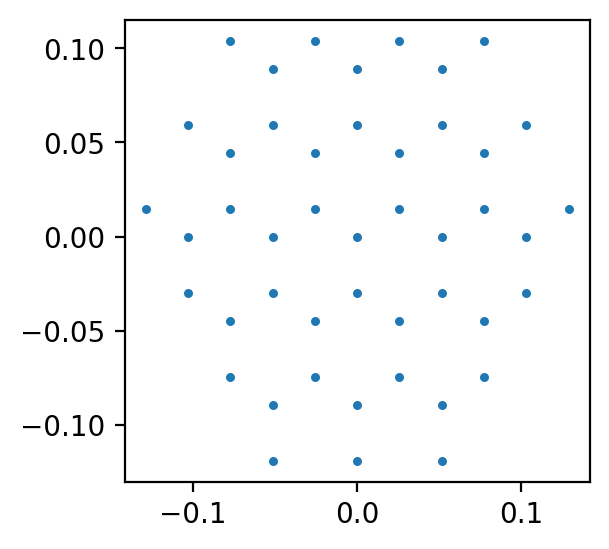

In [8]:
f = plt.figure(figsize=(3, 3), dpi=200)
plt.scatter(np.array(list((k_dict.values())))[:, 0], np.array(list((k_dict.values())))[:, 1], s=5)